In [2]:
"""
Clip morphology rasters to extent of meteorological data
"""
#py_data_analysis
import os
from osgeo import gdal
import glob
from rasterio.crs import CRS
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import mhm_dataprocessing as mdp
import geopandas as gpd

#### Clip Morph files with Bounding box

In [19]:
# === Paths ===
input_path = r'W:\VUB\_main_research\mHM\mhm_belgium\morph_with_crs'
output_path = r'W:\VUB\_main_research\mHM\mhm_belgium\EOBS\morph_BE'

# === Bounding box clipping coordinates ===
# Define in (minX, minY, maxX, maxY) = (lon_min, lat_min, lon_max, lat_max)
bbox = (2.5, 49.5, 6.5, 51.5)

# === Ensure output folder exists ===
os.makedirs(output_path, exist_ok=True)

# === List .asc raster files ===
raster_list = glob.glob(os.path.join(input_path, '*.asc'))

for raster in raster_list:
    raster_name = os.path.basename(raster)
    output_raster = os.path.join(output_path, raster_name)

    # Set warp options with bounding box
    options = gdal.WarpOptions(
        outputBounds=bbox,
        dstNodata=-9999,
        format='AAIGrid'
    )

    # Perform clipping
    out_ds = gdal.Warp(output_raster, raster, options=options)

    if out_ds is not None:
        out_ds = None  # Close file
        print(f"Clipped: {raster_name}", end='\r')
    else:
        print(f"Clipping failed for: {raster_name}", end='\r')


#### Clip meteorological files nc using a shapefile

In [ ]:
## clip netcdf files to the same extent of the shapefile
input_path = r"W:\VUB\_main_research\mHM\mhm_outputs\mHM_EOBS"
output_path = r"W:\VUB\_main_research\mHM\mhm_outputs\mHM_EOBS\tmp_workingfiles"
shapefile = r"W:\VUB\_main_research\mHM\mhm_belgium\be_shp\belgium_joined.shp"

shp = gpd.read_file(shapefile)
os.makedirs(output_path, exist_ok=True)

#read nc files
met_data = glob.glob(os.path.join(input_path, '*L123.nc'))

#clip the netcdf files to the shapefile using the mhm_dataprocessing clip_to_region function

for met_file in met_data:
    xr_dataset = xr.open_dataset(met_file)

    #rename latitude and longitude to match the mhm grid
    if 'latitude' in xr_dataset.dims and 'longitude' in xr_dataset.dims:
        xr_dataset = xr_dataset.rename({'latitude': 'lat', 'longitude': 'lon'})
    
    # Clip to the region defined by the shapefile
    output_file = os.path.join(output_path, os.path.basename(met_file))

    clipped_file = mdp.clip_to_region(shp, xr_dataset)

    #export the clipped dataset to a new netcdf file
    #clipped_file.to_netcdf(output_file)


#### Mask regions with no data in the clipped file

In [12]:

#Mask the regions of the clipped dataset where variance is zero
# This is useful to avoid processing areas with no data

var_threshold = 0.0001  # Define a threshold for variance

mhm_variable = clipped_file['SM_L123']  
variance = mhm_variable.var(dim='time', skipna=True)
# Create a mask where variance is not zero
mask = variance > var_threshold
# Apply the mask to the clipped dataset
clipped_file = clipped_file.where(mask)

# Export the masked dataset to a new netcdf file
output_file = os.path.join(output_path, 'masked_' + os.path.basename(met_file))
clipped_file.to_netcdf(output_file)

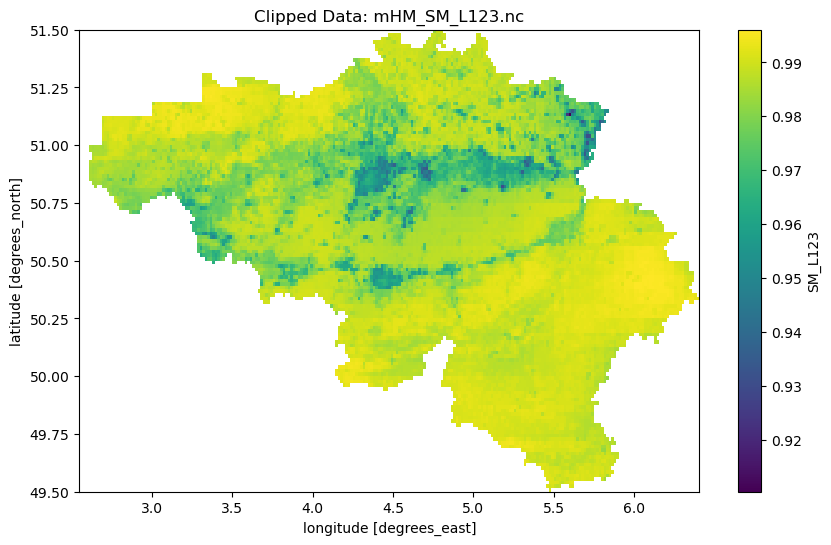

In [13]:
#plot the clipped data to check
plt.figure(figsize=(10, 6))
clipped_file['SM_L123'].isel(time=0).plot()  # Plotting the first time step of temperature
plt.title(f"Clipped Data: {os.path.basename(met_file)}")
plt.show()